In [1]:
import os
from os.path import expanduser
import socket
import sys
import glob

# BELOW IS SYSTEM/PATH CONFIGURATION #
my_home = expanduser("~")
running_system = socket.gethostname()
# Configure machine's names here #
systemHLRN = 'blogin1'
systemLOCAL = 'Laurents-MacBook-Pro.local'
my_home = expanduser("~")
# Define local pass #
wd_path = '/home/hbkoziel/pyfesom/'

#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')
#########################################

In [2]:
import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import time
from scipy.interpolate import griddata
import xarray as xr
import pandas as pd
from PiecewiseNorm import PiecewiseNorm
sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

No joblib
no cmocean


In [3]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'             # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'mixlay'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [4]:
dates = pd.date_range('1985', freq="M", periods= 12*len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = dates
#data.time.data = dates

In [5]:
data

<xarray.Dataset>
Dimensions:  (nod2d: 753179, time: 372)
Coordinates:
  * time     (time) datetime64[ns] 1985-01-31 1985-02-28 ... 2015-12-31
Dimensions without coordinates: nod2d
Data variables:
    mixlay   (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
Attributes:
    description:  mixed layer thickness
    history:      Created Wed Dec  9 13:29:42 2020

In [6]:
din_sel = data.mixlay.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
din_sel = din_sel.compute()

In [7]:
#din_march_mean = data.tr01.sel(time=data.time[2::12]).mean(dim='time')
din_march_mean = din_sel[data['time.month']==3].mean(dim='time')
din_march_mean = din_march_mean.compute()
din_sept_mean = din_sel[data['time.month']==9].mean(dim='time')
din_sept_mean = din_sept_mean.compute()

In [8]:
# WOA data
f          = Dataset('/scratch/usr/hbkoziel/input/mld_DR003.nc', 'r')
date   = -f.variables['time'][:]                                # Depth is negative
lonwoa     =  f.variables['lon'][:]
lonwoa360 = np.arange(-180,180,2)
latwoa     =  f.variables['lat'][:]
DSiwoa     =  f.variables['mld'][:,:,:]
#DSiwoa     = np.squeeze(DSiwoa)
DSiwoa     = np.ma.filled(DSiwoa, np.nan)                            # From masked array to numpy array
        
X360, Y180 = np.meshgrid(lonwoa360, latwoa)

aux = DSiwoa[3,:,:]
aux = np.hstack((aux[:,90:],aux[:,:90]))
ind   = ~np.isnan(aux) 
mld_3           = griddata((X360[ind], Y180[ind]), np.squeeze(aux[ind]), (X360, Y180), method='nearest')                             # 2D field without nans                           

aux = DSiwoa[9,:,:]
aux = np.hstack((aux[:,90:],aux[:,:90]))
ind   = ~np.isnan(aux) 
mld_9           = griddata((X360[ind], Y180[ind]), np.squeeze(aux[ind]), (X360, Y180), method='nearest')   

obs_mld_3 = griddata((X360.ravel(), Y180.ravel()), mld_3.ravel(), (mesh.x2, mesh.y2), method='nearest')  # Final interpolated field
obs_mld_9 = griddata((X360.ravel(), Y180.ravel()), mld_9.ravel(), (mesh.x2, mesh.y2), method='nearest')  # Final interpolated field

obs_mld_3[obs_mld_3>3000]=np.nan
obs_mld_9[obs_mld_9>3000]=np.nan

In [9]:
obs_mld_9, elem_no_nan_91 = pf.get_data(obs_mld_9,mesh,0)
fesom_mld_9, elem_no_nan_92 = pf.get_data(din_sept_mean,mesh,0)
diff_9 = fesom_mld_9-obs_mld_9
diff_9, elem_no_nan_93 = pf.get_data(diff_9,mesh,0)

For depth 0 model level 0.0 will be used
For depth 0 model level 0.0 will be used
For depth 0 model level 0.0 will be used


In [10]:
obs_mld_3, elem_no_nan_31 = pf.get_data(obs_mld_3,mesh,0)
fesom_mld_3, elem_no_nan_32 = pf.get_data(din_march_mean,mesh,0)
diff_3 = fesom_mld_3-obs_mld_3
diff_3, elem_no_nan_33 = pf.get_data(diff_3,mesh,0)

For depth 0 model level 0.0 will be used
For depth 0 model level 0.0 will be used
For depth 0 model level 0.0 will be used


In [11]:
viridis = cm.viridis

1


/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


1


/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in greater
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less


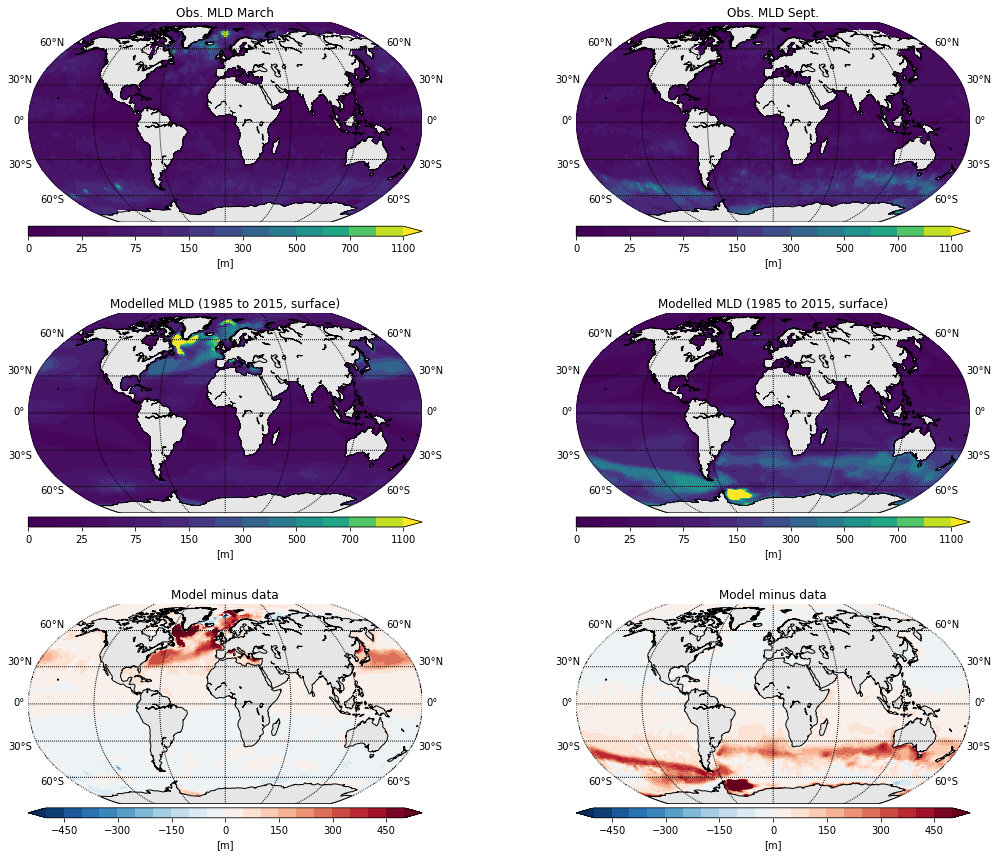

In [17]:
contours=np.array([0, 10, 25, 50, 75, 100, 150, 200, 300, 400, 500, 600, 700, 900, 1100]);
contours1 = [-500, 500, 50.]
contours1 = np.arange(contours1[0], contours1[1]+contours1[2], contours1[2])

unit = '[m]'


fig = plt.figure(num=21, figsize=(16, 12), facecolor='w', edgecolor='k')


ax=plt.subplot(321)   
map = Basemap(projection='robin',lon_0=0) 
x, y = map(mesh.x2, mesh.y2)
map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()
mlabels=[False,False,False,False]
plabels=[True,True,True,True]		    
map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
im=plt.tricontourf(x, y, elem_no_nan_31, obs_mld_3, levels=contours, cmap=viridis, extend='max')
label = 'Obs. MLD March'
plt.title(label)
cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(unit) 
print 1
    
ax=plt.subplot(323)   
map = Basemap(projection='robin',lon_0=0) 
x, y = map(mesh.x2, mesh.y2)
map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()
mlabels=[False,False,False,False]
plabels=[True,True,True,True]		    
map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
im=plt.tricontourf(x, y, elem_no_nan_32, fesom_mld_3, levels=contours, cmap=viridis, extend='max')
label = 'Modelled MLD'+' ('+str(years[0])+' to '+str(years[len(years)-1])+', surface)'
plt.title(label)
cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(unit) 
        
ax=plt.subplot(325)
map = Basemap(projection='robin',lon_0=0) 
x, y = map(mesh.x2, mesh.y2)
map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()
mlabels=[False,False,False,False]
plabels=[True,True,True,True]		    
map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
diff_3[diff_3>500] = 500
diff_3[diff_3<-500] = -500
im=plt.tricontourf(x, y, elem_no_nan_33, diff_3, cmap='RdBu_r',levels=contours1 ,extend='both')
label = ''+'Model minus data' +'' 
plt.title(label)
cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(unit) 

ax=plt.subplot(322)   
map = Basemap(projection='robin',lon_0=0) 
x, y = map(mesh.x2, mesh.y2)
map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()
mlabels=[False,False,False,False]
plabels=[True,True,True,True]		    
map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
im=plt.tricontourf(x, y, elem_no_nan_91, obs_mld_9, levels=contours, cmap=viridis, extend='max')
label = 'Obs. MLD Sept.'
plt.title(label)
cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(unit) 
print 1
    
ax=plt.subplot(324)   
map = Basemap(projection='robin',lon_0=0) 
x, y = map(mesh.x2, mesh.y2)
map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()
mlabels=[False,False,False,False]
plabels=[True,True,True,True]		    
map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
im=plt.tricontourf(x, y, elem_no_nan_92, fesom_mld_9, levels=contours, cmap=viridis, extend='max')
label = 'Modelled MLD'+' ('+str(years[0])+' to '+str(years[len(years)-1])+', surface)'
plt.title(label)
cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(unit) 
        
ax=plt.subplot(326)
map = Basemap(projection='robin',lon_0=0) 
x, y = map(mesh.x2, mesh.y2)
map.drawmapboundary(fill_color='0.9')
map.drawcoastlines()
mlabels=[False,False,False,False]
plabels=[True,True,True,True]		    
map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
diff_9[diff_9>500] = 500
diff_9[diff_9<-500] = -500
im=plt.tricontourf(x, y, elem_no_nan_93, diff_9, cmap='RdBu_r',levels=contours1 ,extend='both')
label = ''+'Model minus data' +'' 
plt.title(label)
cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(unit) 
        
plt.tight_layout(h_pad=3.0)
plt.show(block=False)

In [13]:
# import matplotlib.pyplot as plt
# fig = plt.figure(num=21, figsize=(24, 12), facecolor='w', edgecolor='k')
# elem2=mesh.elem[mesh.no_cyclic_elem,:]
# d=obs_mld_3[elem2].mean(axis=1)
# k = [i for (i, val) in enumerate(d) if not np.isnan(val)]
# elem2=elem2[k,:]
# print 'ftriplot, number of dummy points:', len(d)-len(k)    
# map = Basemap(projection='robin',lon_0=0) 
# x, y = map(mesh.x2, mesh.y2)
# map.drawmapboundary(fill_color='0.9')
# map.drawcoastlines()
# mlabels=[False,False,False,False]
# plabels=[True,True,True,True]		    
# map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
# map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
# im=plt.tricontourf(x, y, elem2, obs_mld_3, levels=contours, cmap=viridis, norm=PiecewiseNorm(contours), extend='max')
# label = 'De boyer Atlas'+':'+'Interpolated MLD'
# plt.title(label)
# cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
# cbar.set_label(unit)